Hikyuu 交互式工具示例
==============

1、引入交互式工具
-----------------
需从hikyuu.interactive引入，而不是直接从hikyuu库中引入（hikyuu是一个库，可用于编制其他的工具，而hikyuu.interactive是基于hikyuu库实现的交互式探索工具）

In [1]:
#%matplotlib inline
%time from hikyuu.interactive import *
#use_draw_engine('echarts') #use_draw_engine('matplotlib')  #默认为'matplotlib'绘图

Initialize hikyuu_2.7.6_202602110020_RELEASE_macosx_arm64 ...
2026-02-11 09:58:25.143 [HKU-I] - current python version: 3.12.7 (main.cpp:74)


2026-02-11 09:58:28,095 [INFO] runing in interactive session [<module>] (/Users/fasiondog/workspace/hikyuu/hikyuu/__init__.py:145) [hikyuu::hku_info]
2026-02-11 09:58:28,095 [INFO] running in jupyter [<module>] (/Users/fasiondog/workspace/hikyuu/hikyuu/__init__.py:152) [hikyuu::hku_info]


2026-02-11 09:58:28.100 [HKU-I] - 插件路径: /Users/fasiondog/workspace/hku_plugin/hikyuu_plugin (StockManager.cpp:107)
2026-02-11 09:58:29.715 [HKU-I] - Using CLICKHOUSE BaseInfoDriver (BaseInfoDriver.cpp:57)
2026-02-11 09:58:29.746 [HKU-I] - 加载市场信息…… (StockManager.cpp:744)
2026-02-11 09:58:29.755 [HKU-I] - 加载证券类型信息…… (StockManager.cpp:761)
2026-02-11 09:58:29.765 [HKU-I] - 加载证券信息…… (StockManager.cpp:642)
2026-02-11 09:58:29.866 [HKU-I] - 加载权息数据…… (StockManager.cpp:778)
2026-02-11 09:58:30.075 [HKU-I] - 加载板块信息…… (StockManager.cpp:176)
2026-02-11 09:58:30.279 [HKU-I] - 加载K线数据…… (StockManager.cpp:180)
2026-02-11 09:58:30.279 [HKU-I] - 预加载 day K线数据至缓存 (最大数量: 100000)! (StockManager.cpp:231)
2026-02-11 09:58:30.280 [HKU-I] - 0.55 秒数据加载完毕. (StockManager.cpp:187)
CPU times: user 1.74 s, sys: 347 ms, total: 2.09 s
Wall time: 5.93 s


2、创建交易系统并运行
--------------------

In [2]:
#创建模拟交易账户进行回测，初始资金30万
my_tm = crtTM(init_cash = 300000)

#创建信号指示器（以5日EMA为快线，5日EMA自身的10日EMA作为慢线，快线向上穿越慢线时买入，反之卖出）
my_sg = SG_Flex(EMA(C, n=5), slow_n=10)

#固定每次买入1000股
my_mm = MM_FixedCount(1000)

#创建交易系统并运行
sys = SYS_Simple(tm = my_tm, sg = my_sg, mm = my_mm)
sys.run(sm['sz000001'], Query(-150))

3、绘制曲线观察
---------------

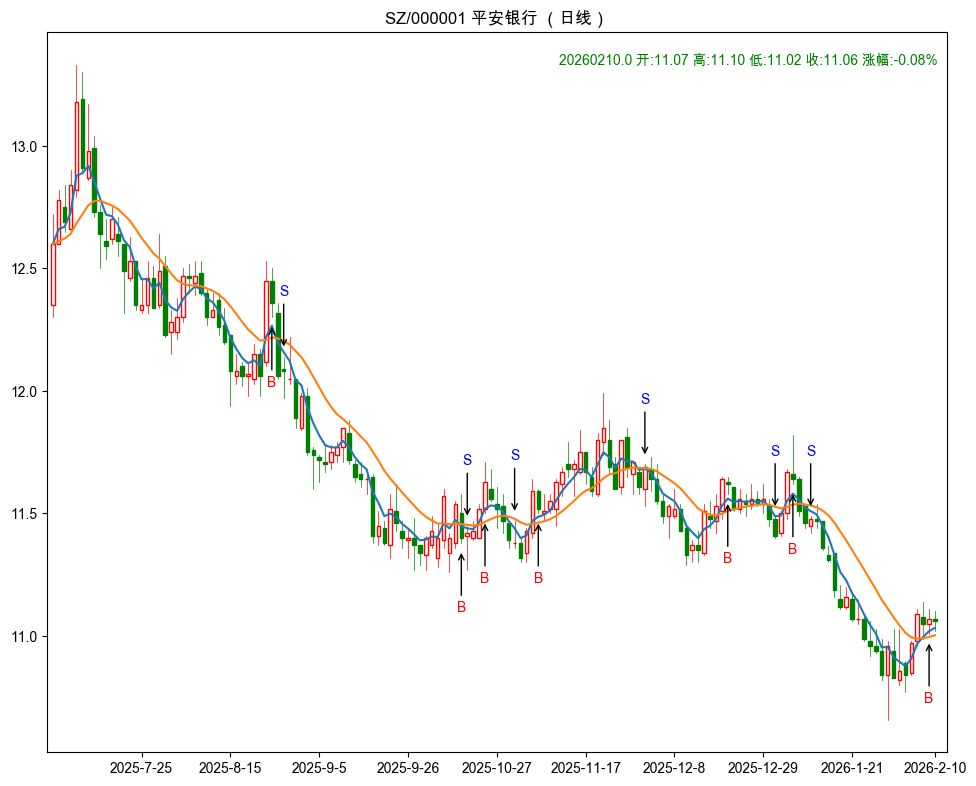

In [3]:
#绘制系统信号
sys.plot()

k = sm['sz000001'].get_kdata(Query(-150))
c = CLOSE(k)
fast = EMA(c, 5)
slow = EMA(fast, 10)

#绘制信号指示器使用两个指标
fast.plot(new=False)
slow.plot(new=False)

4、绘制资金收益曲线
---------------------

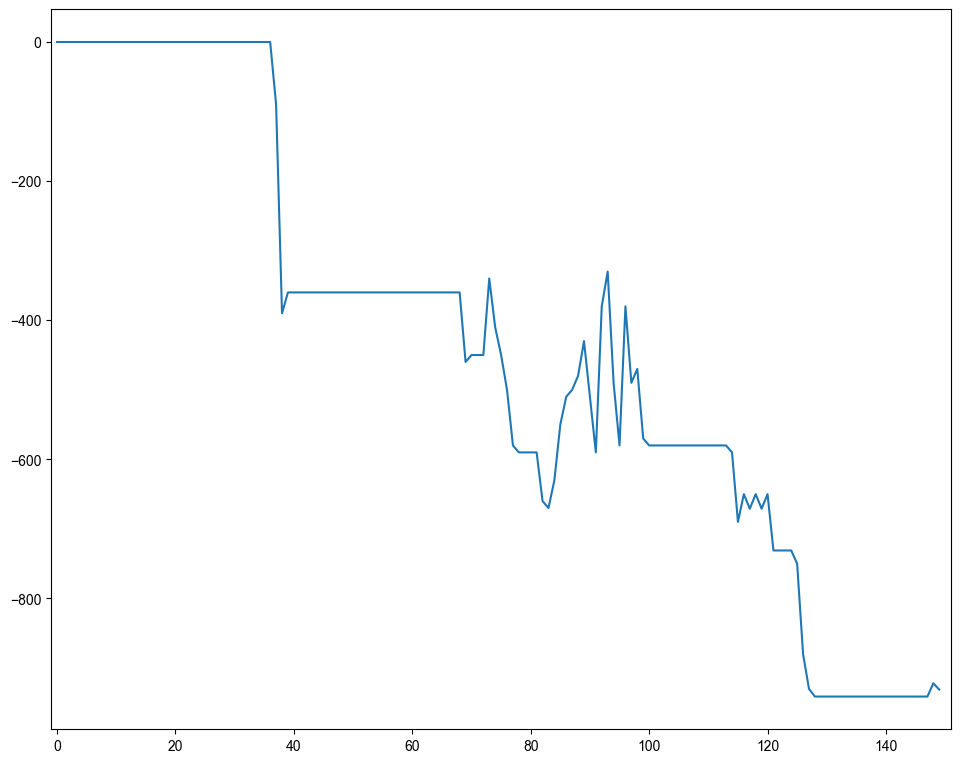

In [4]:
#绘制资金收益曲线
x = my_tm.get_profit_curve(k.get_datetime_list(), Query.DAY)
x = PRICELIST(x)
x.plot()

5、回测统计报告
----------------------

In [5]:
#回测统计
from datetime import datetime

per = my_tm.get_performance()
print(per.to_df())


                         name          value
0                帐户初始金额  300000.000000
1                累计投入本金  300000.000000
2                累计投入资产       0.000000
3                累计借入现金       0.000000
4                累计借入资产       0.000000
5                    累计红利       0.000000
6                    现金余额  288009.000000
7              未平仓头寸净值   11060.000000
8                  当前总资产  299069.000000
9            已平仓交易总成本       0.000000
10           已平仓净利润总额    -941.000000
11  单笔交易最大占用现金比例%       4.150000
12      交易平均占用现金比例%       3.882797
13          未平仓帐户收益率%      -0.310333
14          已平仓帐户收益率%      -0.313667
15          帐户年复合收益率%      -0.665118
16          帐户平均年收益率%      -0.666304
17           赢利交易赢利总额      10.000000
18           亏损交易亏损总额    -951.000000
19             已平仓交易总数       6.000000
20                 赢利交易数       1.000000
21                 亏损交易数       5.000000
22              赢利交易比例%      16.666667
23                 赢利期望值    -156.833333
24           赢利交易平均赢利      10.000000
25

6、关于性能
---------------

经常有人问到性能问题，下面这段的代码使用之前的系统示例，遍历指定板块的所有股票，计算他们的“盈利交易比例%”（即胜率）。

In [8]:
def test_func(stock, query):
    """计算指定stock的系统策略胜率，系统策略为之前的简单双均线交叉系统（每次固定买入100股）
    """
    #创建模拟交易账户进行回测，初始资金30万
    my_tm = crtTM(init_cash = 1000000)

    #创建信号指示器（以5日EMA为快线，5日EMA自身的10日EMA作为慢线，快线向上穿越慢线时买入，反之卖出）
    my_sg = SG_Flex(EMA(C, n=5), slow_n=10)

    #固定每次买入1000股
    my_mm = MM_FixedCount(100)

    #创建交易系统并运行
    sys = SYS_Simple(tm = my_tm, sg = my_sg, mm = my_mm)
    sys.run(stock, query)
    
    per = my_tm.get_performance(ext=False)
    return per["赢利交易比例%"]

def total_func(blk, query):
    """遍历指定板块的所有的股票，计算系统胜率"""
    result = {}
    for s in blk:
        if s.valid and s.type != constant.STOCKTYPE_INDEX:
            result[s.name] = test_func(s, query)
    return result

遍历所有当前有效且并非指数的证券。下面是我的机器执行结果，共计算4151支证券，最近500个交易日，共耗时2.89秒。机器配置：Intel i7-4700HQ 2.G。

In [9]:
%time a = total_func(sm, Query(-500))
len(a)

CPU times: user 1.17 s, sys: 28.1 ms, total: 1.2 s
Wall time: 1.2 s


7261

In [ ]:
# 10年 7000+ 支股票，vectorBT 的10倍速
%time a = total_func(sm, Query(Datetime(20150101), Datetime(20260101)))
len(a)

CPU times: user 3.9 s, sys: 79.1 ms, total: 3.97 s
Wall time: 3.99 s


7261